In [2]:
# Word level one-hot encoding
import numpy as np

samples=['The cat sat on the mat.', 'The dog ate my homework.']

# First, build an index of all tokens in the data.
token_index={}
for sample in samples:
    for word in sample.split():
        if word not in token_index:
            token_index[word]=len(token_index)+1
            
# Next, we vectorize our samples.
max_length=10
results=np.zeros((len(samples), max_length, max(token_index.values())+1))
for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index=token_index.get(word)
        results[i,j,index]=1.

In [3]:
# Character level one-hot encoding
import string

samples=['The cat sat on the mat.','The dog ate my homework.']
# all printable ASCII characters
characters=string.printable
token_index=dict(zip(range(1,len(characters)+1), characters))

max_length=50
results=np.zeros((len(samples), max_length, max(token_index.keys())+1))
for i, sample in enumerate(samples):
    for j, character in enumerate(sample):
        index=token_index.get(character)
        results[i,j,index]=1

In [8]:
# use keras for word-level one-hot encoding
from keras.preprocessing.text import Tokenizer

samples=['The cat sat on the mat.','The dog ate my homework.']

# create a tokenizer ,configured to only take into account the top-1000 most common words
tokenizer=Tokenizer(num_words=1000)
# build the word index
tokenizer.fit_on_texts(samples)

# this returns strings into lists of integer indices
sequences=tokenizer.texts_to_sequences(samples)
print('sequences:',sequences)

# get the one-hot binary representations
one_hot_results=tokenizer.texts_to_matrix(samples, mode='binary')
print('one_hot_results:',one_hot_results.shape)

# recover the word index that was computed
word_index=tokenizer.word_index
print('Found %s unique tokens.'%len(word_index))

sequences: [[1, 2, 3, 4, 1, 5], [1, 6, 7, 8, 9]]
one_hot_results: (2, 1000)
Found 9 unique tokens.


In [10]:
# word-level one-hot encoding with hashing trick
samples=['The cat sat on the mat.','The dog ate my homework.']

dimensionality=1000
max_length=10

results=np.zeros((len(samples), max_length, dimensionality))
for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        # hash the word into a 'random' integer index that is between 0 and 1000
        index=abs(hash(word))%dimensionality
        results[i,j,index]=1

print(results)

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


In [11]:
# Learn word embeddings with the embedding layer
from keras.layers import Embedding

# 1000 means the number of possible tokens
# 64 means the dimensionality of the embedding
embedding_layer=Embedding(1000,64)

In [14]:
# Use an embedding layer and classifier on the IMDB data
from keras.datasets import imdb
from keras import preprocessing
from keras.models import Sequential
from keras.layers import Flatten, Dense

max_features=10000
# cut texts after this number of words
maxlen=20
(x_train, y_train),(x_test, y_test)=imdb.load_data(num_words=max_features)

# turn lists of integers into a 2D integer tensor of shape (samples, maxlen)
x_train=preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test=preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

model=Sequential()
# after embedding layer, the activations have shape (samples, maxlen, 8)
model.add(Embedding(10000, 8, input_length=maxlen))
# flatten the 3D tensor into a 2D tensor of shape (samples, maxlen*8)
model.add(Flatten())
# add the classifier on the top
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history=model.fit(x_train,y_train,epochs=10,batch_size=32,validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten_2 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 2s 92us/step - loss: 0.6759 - acc: 0.6045 - val_loss: 0.6399 - val_acc: 0.6806
Epoch 2/10
20000/20000 [==============================] - 2s 81us/step - loss: 0.5660 - acc: 0.7428 - val_loss: 0.5470 - val_acc: 0.7196
Epoch 3/10
20000/20000 [==============================] - 2s 79us/step - loss: 

In [17]:
# Use pre-trained word embeddings (suitable for small training dataset)
# from raw text to word embeddings
import os

imdb_dir='/Users/think/Downloads/aclImdb'
train_dir=os.path.join(imdb_dir,'train')

labels=[]
texts=[]

for label_type in ['neg','pos']:
    dir_name=os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:]=='.txt':
            f=open(os.path.join(dir_name,fname),encoding='utf8')
            texts.append(f.read())
            f.close()
            if label_type=='neg':
                labels.append(0)
            else:
                labels.append(1)

In [19]:
# tokenize the text of the raw IMDB data
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen=100
train_samples=200
validation_samples=10000
max_words=10000  # only consider the top 10000 words in the dataset

tokenizer=Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences=tokenizer.texts_to_sequences(texts)

word_index=tokenizer.word_index
print('Found %s unique tokens' %len(word_index))

data=pad_sequences(sequences, maxlen=maxlen)
labels=np.asarray(labels)
print('Shape of data tensor:',data.shape)
print('Shape of label tensor:',labels.shape)

# shuffle the data before splitting it into training set and validation set
indices=np.arange(data.shape[0])
np.random.shuffle(indices)
data=data[indices]
labels=labels[indices]

x_train=data[:train_samples]
y_train=labels[:train_samples]
x_val=data[train_samples:validation_samples]
y_val=labels[train_samples:validation_samples]

Found 88582 unique tokens
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


In [20]:
# parse the GloVe word embeddings file
glove_dir='/Users/think/Downloads/glove.6B'

embeddings_index={}
f=open(os.path.join(glove_dir,'glove.6B.100d.txt'),encoding='utf8')
for line in f:
    values=line.split()
    word=values[0]
    coefs=np.asarray(values[1:],dtype='float32')
    embeddings_index[word]=coefs
f.close()
print('Found %s word vectors.'%len(embeddings_index))

Found 400000 word vectors.


In [21]:
# prepare the glove word embeddings matrix
embedding_dim=100
embedding_matrix=np.zeros((max_words,embedding_dim))
for word,i in word_index.items():
    embedding_vector=embeddings_index.get(word)
    if i<max_words:
        if embedding_vector is not None:
            # words not found in embedding matrix will be all-zeros
            embedding_matrix[i]=embedding_vector

In [22]:
# define a model
model=Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_3 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [23]:
# load the pre-trained word embeddings into the Embedding layer
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainabel=False

# train and evaluation
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])
history=model.fit(x_train,y_train,epochs=10,batch_size=32,validation_data=(x_val,y_val))
model.save_weights('pre_trained_glove_model.h5')

Train on 200 samples, validate on 9800 samples
Epoch 1/10
200/200 [==============================] - 1s 6ms/step - loss: 1.6332 - acc: 0.5250 - val_loss: 0.6950 - val_acc: 0.5151
Epoch 2/10
200/200 [==============================] - 1s 5ms/step - loss: 0.6707 - acc: 0.6200 - val_loss: 1.1597 - val_acc: 0.5080
Epoch 3/10
200/200 [==============================] - 1s 5ms/step - loss: 0.6300 - acc: 0.6800 - val_loss: 0.6975 - val_acc: 0.5676
Epoch 4/10
200/200 [==============================] - 1s 5ms/step - loss: 0.3852 - acc: 0.8650 - val_loss: 0.7007 - val_acc: 0.5719
Epoch 5/10
200/200 [==============================] - 1s 6ms/step - loss: 0.2194 - acc: 0.9200 - val_loss: 0.7919 - val_acc: 0.5465
Epoch 6/10
200/200 [==============================] - 1s 5ms/step - loss: 0.1301 - acc: 0.9650 - val_loss: 0.7199 - val_acc: 0.5812
Epoch 7/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0869 - acc: 0.9900 - val_loss: 3.2297 - val_acc: 0.4931
Epoch 8/10
200/200 [=========

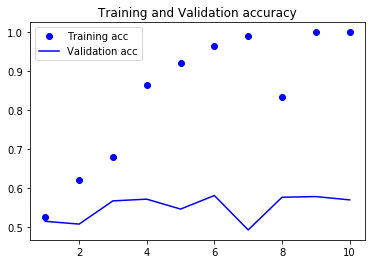

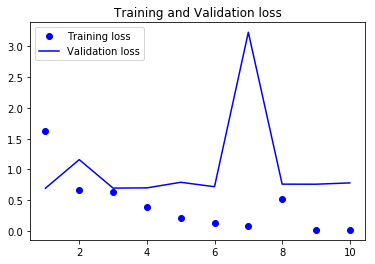

In [24]:
# plot the result
import matplotlib.pyplot as plt

acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(acc)+1)

plt.plot(epochs,acc,'bo',label='Training acc')
plt.plot(epochs,val_acc,'b',label='Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

In [25]:
# define a model without pre-trained word embeddings
model=Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])
history=model.fit(x_train,y_train,epochs=10,batch_size=32,validation_data=(x_val,y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_4 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Train on 200 samples, validate on 9800 samples
Epoch 1/10
200/200 [==============================] - 1s 7ms/step - loss: 0.6951 - acc: 0.4350 - val_loss: 0.6950 - val_acc: 0.5176
Epoch 2/10
200/200 [==============================] - 1s 5ms/step - loss: 0.5024 - ac

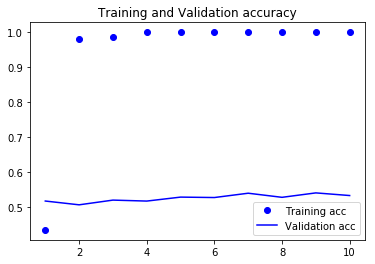

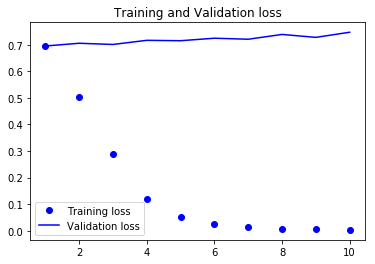

In [26]:
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(acc)+1)

plt.plot(epochs,acc,'bo',label='Training acc')
plt.plot(epochs,val_acc,'b',label='Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

In [27]:
test_dir=os.path.join(imdb_dir,'test')

labels=[]
texts=[]

for label_type in ['neg','pos']:
    dir_name=os.path.join(test_dir,label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:]=='.txt':
            f=open(os.path.join(dir_name,fname),encoding='utf8')
            texts.append(f.read())
            f.close()
            if label_type=='neg':
                labels.append(0)
            else:
                labels.append(1)
sequences=tokenizer.texts_to_sequences(texts)
x_test=pad_sequences(sequences,maxlen=maxlen)
y_test=np.asarray(labels)

model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test,y_test)

25000/25000 [==============================] - 3s 112us/step


[0.7814178762817383, 0.57124]